# Learning Discrete-Time Estimation and Control with Transformers

In [12]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

from utils import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 2000 # how long to simulate the trajectory # 100
# num_traj_train = 100; num_traj_test = 20
# num_traj = num_traj_train + num_traj_test
num_traj = 1

# State Estimation: Continuous State Space 

Dynamical System:

$\vec{x}_{t+1} = A\vec{x}_t + B \vec{u}_t + \vec{w}_t$ is the Transition Model, where $\vec{w}_t \sim \mathcal{N}(\vec{0}, Q)$ is process noise

$\vec{y}_t = C\vec{x}_t + \vec{v}_t$ is Observation Model, where $\vec{v}_t \sim \mathcal{N}(\vec{0}, R)$ is sensor noise

## Generate Trajectories

In [13]:
task_name = 'spring_mass_damper' # Choose from 'circular', 'motion', 'so3', 'accel', 'spring_mass_damper'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]
print("A", A.shape)
print("B", B.shape)
print("C", C.shape)

u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

A (2, 2)
B (2, 1)
C (1, 2)


Trajectory shape (2000, 2)
Measured shape (2000, 1)


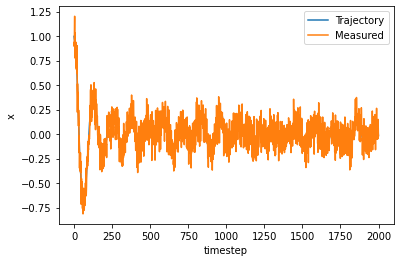

In [14]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

## 1. Kalman Filtering using known A, B to estimate $\mathbb{E}[X_t | y_1, y_2, ... y_n]$

### 1a. Recalculating gains at each timestep until convergence

In [15]:
kfiltered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kfiltered[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr = np.linalg.norm(kfiltered - traj)**2 / num_traj / T
    
print("Average Squared Error:", err_fltr)

Converged in 77 iterations
Average Squared Error: 0.002790391127797704


Trajectory shape (2000, 2)
Measured shape (2000, 1)
Filtered shape (2000, 2)


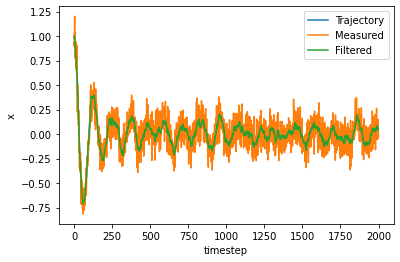

In [16]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered[0]})

### 1b. Kalman Filter with pure steady state gains

In [17]:
kfiltered_ss = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    kinematics_forward.run_till_ss()
    kfiltered_ss[i] = kinematics_forward.simulate(meas[i], u_seq[i])
    
err_fltr_ss = np.linalg.norm(kfiltered_ss - traj)**2 / num_traj / T

print("Average Squared Error", err_fltr_ss)

Converged in 0 iterations
Average Squared Error 0.00279648922683334


Trajectory shape (2000, 2)
Measured shape (2000, 1)
Filtered shape (2000, 2)


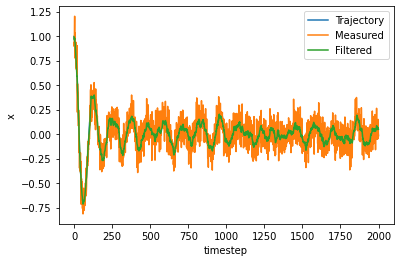

In [18]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': kfiltered_ss[0]})

## 2. Least Squares System ID + Kalman Filtering

###  2a Update on the identified system at each timestep
The following cell takes about 40 seconds to run.

Note - The System Identification as implemented currently requires the state dimension to match the obs dimension.

In [8]:
id_filtered = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim))
    kinematics = KFilter(A_unk, B_unk, C, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered[i] = id_fltr
    
err_id_fltr = np.linalg.norm(id_filtered[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Filtered': id_filtered[0]})

### 2b Kalman filter for each timestep simulated from the start

The cell below takes about 5 minutes to run.

In [ ]:
err_id_fltr_sim = 0
id_filtered_simulated = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    id_fltr_sim = np.zeros(shape=(T,state_dim))
    for t in range(1, T):
        A_found, B_found = system_id(meas[i], t, x0, u_seq[i])
        kinematics = KFilter(A_found, B_found, C, Q, R, x0)
        id_fltr_sim[t] = kinematics.simulate(meas[i, :t], u_seq[i, :t])[-1]
    id_filtered_simulated[i] = id_fltr_sim
    
err_id_fltr_sim = np.linalg.norm(id_filtered_simulated[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr_sim)

In [ ]:
plot({"Trajectory:": traj[0], "ID + Filtered": id_filtered_simulated[0]})

## 3. Learning a Kalman Filter at each timestep: A and B are unknown

Nonlinear system ID of the Kalman Filter parameters:
$$\tilde{x}_{t+1} = A(I - KC)\tilde{x}_t + B u_t + AKy_t$$
$$\tilde{x}_{t+1} = A'\tilde{x}_t + B' u_t + G'y_t $$ 

where $A' = A(I - KC)$, $B' = B$, $G'= AK$

Observations
$$y_t = C' x_t$$ 

The following cell takes around 20 minutes per trajectory that you want to fit your KF on. In general, it is easiest to just train it on one.

In [ ]:
err_learned_kf = 0
learned_kfs = []
learned_kfs_simulated = np.zeros(shape=(num_traj, T, state_dim))

if True:
    i = 0
# for i in range(num_traj_train, num_traj):
    kinematics = LearnedKFilter(state_dim, input_dim, obs_dim, x0)
    kinematics.fit(meas[i], u_seq[i], eps=2, maxIt=15000)
    learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
    learned_kfs_simulated[i] = learned_kf_sim
    learned_kfs.append(kinematics)

    plt.figure()
    plt.plot(kinematics.losses[30:])
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

    err_learned_kf = np.linalg.norm(learned_kf_sim[CUT:, :] - traj[i,CUT:, :])**2

print("Average Squared Error", err_learned_kf / T) #num_traj_test / T)

In [ ]:
learned_kf_sim = kinematics.simulate(meas[i], u_seq[i])
learned_kfs_simulated[i] = learned_kf_sim
learned_kfs.append(kinematics)
plot({'Trajectory': traj[0], "Optimal KF": kfiltered[0], "Learned KF simulated": learned_kfs_simulated[0]})

In [ ]:
# The cell below is useful to compare the LearnedKF parameters to true parameters of the Kalman Filter
# learned_kf = learned_kfs[0]
# true_kf = KFilter(A, B, C, Q, R, state=x0)
# true_kf.run_till_ss()
# print("Aprime true is", A - A @ true_kf.K @ true_kf.C)
# print("Aprime learned is", learned_kf.Aprime)
# print("Bprime true is", B)
# print("Bprime learned is", learned_kf.Bprime)
# print("Gprime true is", A @ true_kf.K)
# print("Gprime learned is", learned_kf.Gprime)
# print("Cprime true is", C)
# print("Cprime learned is", learned_kf.Cprime)

## ZOH Baseline 
Quantify the error if we just predict the previous token (identity map) - ie. no learning involved

In [ ]:
error = 0
for i in range(num_traj):
    for t in range(1,T):
        error += np.linalg.norm(meas[i, t] - meas[i, t-1])**2
print("Error is", error / num_traj / T)

# Transformer-based techniques to learn the dynamics and filter the position

In [ ]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

In [ ]:
# Training Data
indices_train = np.arange(num_traj_train)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
true_positions_train = torch.from_numpy(traj)[indices_train,:,:]


# Test Data
indices_test = np.arange(num_traj_train, num_traj)
traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)[indices_test,:,:]

## GPT-style: Transformer Decoder only for Autoregressive generation

The following cell takes around 15 minutes to run.

In [ ]:
num_epochs = 200

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=state_dim,
                n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  #TRYING TO HIT NOISY DATA

        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)
        loss = loss_func(decoder_output, target_sequence_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")

plt.show()

In [ ]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
ind_to_vis = 3 # 0 through 19

filtered = gpt_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by GPT', color='g')
linetrueKF, = ax.plot(kfiltered[ind_to_vis+num_traj_train, CUT:, 0], kfiltered[ind_to_vis+num_traj_train, CUT:, 1], label="Optimal KF", color='r')

plt.legend()
plt.show()

#print('Average Squared Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
#print('Average Squared Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)

## BERT-style: Transformer Encoder only, fill in trajectory

Note - we are taking advantage of the ground truth (TRUE TRAJECTORY) here! 
The following cell takes about 15 minutes to run.

In [ ]:
num_epochs = 200
# p = 0.15 # probability of zeroing out a token

# bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
#                 embed_size=embed_dim, output_size=state_dim, 
#                 n_layers=4, n_heads=6, d_filter=64, 
#                 dropout=None)
# optimizer = torch.optim.Adam(bert_model.parameters())

loss_func = torch.nn.MSELoss(reduction='sum')
# losses = []

for i in range(num_epochs):
    for batchNum in range(num_traj_train // batch_size):
        
        # Randomly zero-out p% of the tokens in transformer_input_train - different for each batch each time
        # If we're trying to hit the true targets, DO NOT MASK!
        # mask = torch.bernoulli( (1-p) * torch.ones(size=(batch_size, T) ) )
        # mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :] # * mask
        
     
        # NO! do NOT use a zero-mask. instead, your mask should be LEARNABLE! you should REPLACE tokens with the mask, NOT MULTIPLY!
        # Do not even use the mask at all. Instead, just try to hit true targets. 
        # FIX THIS
        
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        true_positions_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, true_positions_batch) #,target_sequences_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

In [ ]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [ ]:
bert_transformer_sim = bert_model(transformer_input_test, encoder_mask=None)

# Index that we want to visualize from the test indices
ind_to_vis = 9

filtered = bert_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
#linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linelstsq = ax.plot(pred_test_traj[ind_to_vis, CUT:, 0], pred_test_traj[ind_to_vis, CUT:, 1], label='Filtered by least squares', color='m')
linebert, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by BERT', color='g')
linetrueKF, = ax.plot(kfiltered[ind_to_vis+num_traj_train, CUT:,0], kfiltered[ind_to_vis+num_traj_train, CUT:,1], label="Optimal KF", color='r')
# linefltr, = ax.plot(learned_kf_sim[CUT:,0], learned_kf_sim[CUT:,1], label="LearnedKF simulated", color='b')

plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / num_traj_test / T)
print('Average Squared Error of BERT', np.linalg.norm(filtered - traj_test)**2 / num_traj_test / T)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / num_traj_test / T)